# Implementation and Visualisation of ID3 Decision Tree

    I first implemented the ID3 algorithm on the tennis data set since 
    we've been working with it in our lectures and it contains only 14
    items, so it's easy to debug the results. 

    At the bottom of this implementation I finally use my resulting ID3 
    decision tree to classify the actual dataset, which is the car dataset
    from the UCI Machine Learning Repository. 
    (source: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation)

    For a Jupyter notebook of this implementation check out my github account:
    www.github.com/reinka/coding/MachineLearning/ID3

### Load modules

In [4]:
import numpy as np 
import pandas as pd
import requests

### Get tennis dataset

In [5]:
url = 'http://cs.carleton.edu/faculty/dmusican/cs321s12/tennis.txt'
headers = {'User-Agent': 'Mozilla/5.0'}

page = requests.get(url, headers)
page.raise_for_status()

In [6]:
with open('tennis.txt', 'wb') as f:
    f.write(page.content)


data = np.genfromtxt('tennis.txt', dtype='str', delimiter='\t')

data.shape

(15, 5)

### Check out data frame

In [7]:
pd.DataFrame(data[1:,:], columns=data[0,:])

,outlook,temperature,humidity,wind,playtennis
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
3,rain,mild,high,weak,yes
4,rain,cool,normal,weak,yes
5,rain,cool,normal,strong,no
6,overcast,cool,normal,strong,yes
7,sunny,mild,high,weak,no
8,sunny,cool,normal,weak,yes
9,rain,mild,normal,weak,yes


### Function that splits data on given class/value of specific colum/attribute

In [8]:
def split(data,column,value):
    # Function that tells us if a row is 
    # in the first group (true) or the second group (false)
    split_function=lambda row:row[column]==value
   
    # Divide the rows into two sets and return them
    set1=[row for row in data if split_function(row)]
    set2=[row for row in data if not split_function(row)]
    return (set1,set2)

#### Test code on outcome labels (index = `-1`). Split data into `yes` and `no` group


In [9]:
# First remove first row 
# since it contains the col names
# save labels for later though
labels = data[0]

# remove first row
data = data[1:]

split(data, -1, 'yes')

([array(['overcast', 'hot', 'high', 'weak', 'yes'], 
        dtype='<U11'), array(['rain', 'mild', 'high', 'weak', 'yes'], 
        dtype='<U11'), array(['rain', 'cool', 'normal', 'weak', 'yes'], 
        dtype='<U11'), array(['overcast', 'cool', 'normal', 'strong', 'yes'], 
        dtype='<U11'), array(['sunny', 'cool', 'normal', 'weak', 'yes'], 
        dtype='<U11'), array(['rain', 'mild', 'normal', 'weak', 'yes'], 
        dtype='<U11'), array(['sunny', 'mild', 'normal', 'strong', 'yes'], 
        dtype='<U11'), array(['overcast', 'mild', 'high', 'strong', 'yes'], 
        dtype='<U11'), array(['overcast', 'hot', 'normal', 'weak', 'yes'], 
        dtype='<U11')], [array(['sunny', 'hot', 'high', 'weak', 'no'], 
        dtype='<U11'), array(['sunny', 'hot', 'high', 'strong', 'no'], 
        dtype='<U11'), array(['rain', 'cool', 'normal', 'strong', 'no'], 
        dtype='<U11'), array(['sunny', 'mild', 'high', 'weak', 'no'], 
        dtype='<U11'), array(['rain', 'mild', 'high', 'stro

#### To calculate the entropy we need to count the occurance of each possible label value

In [10]:
def count_labels(data):
    # initialize (key,value) dict (hash-map)
    count = dict()
    
    for row in data:
        
        # our output labels (y) are the last column
        label = row[-1]
        
        # initialize `key` of dict if 
        # label hasn't occured before
        if label not in count:
            count[label] = 0
            
        # increment by 1
        count[label] += 1
        
    return count


#### Count number of occurances of each output label over the whole data frame

In [11]:
count_labels(data)

{'no': 5, 'yes': 9}

### Count occurences of split data set with respect to a specific column and class
    here with respect to `outlook` (column 0) and class `sunny`

In [12]:
count_labels(split(data, 0, 'sunny')[0])

{'no': 3, 'yes': 2}

    So splitting the data set with respect to 
    `outlook` == `sunny` yields 3 x `no` and 2 x `yes`
     
    Let's check the other branch:

In [13]:
count_labels(split(data,0,'sunny')[1])

{'no': 2, 'yes': 7}

### We have now the tools to get to the entropy

$$H = \sum_{i = 1}^c -p_i * log_c(p_i)$$

In [14]:
def entropy(s):
    result = count_labels(s)
    from math import log2
    entropie = 0.0
    
    # for each label
    for label in result.keys():
        # calculate p first
        # => relative frequency
        p = float(result[label])/len(s)
        # if p not 0
        if(p):
            # calc entropy
            entropie -= p * log2(p)
        
    return entropie

### Test code
     Split data set by `sunny` and 
     calculate entropy for each split after that

In [15]:
a, b = split(data,0,'sunny')

# print(count_labels(a),count_labels(b))
print(entropy(a), entropy(b))




0.9709505944546686 0.7642045065086203


#### Compare to entropy of whole data set


In [16]:
entropy(data)

0.9402859586706311

    same result as on slide 12, lecture 3

#### Decision tree finally

In [17]:

class node:
    def __init__(self, attribute = -1, entropie=None, value = None,
                 results=None, fchild=None, tchild=None):
        self.col = self.get_attr(attribute)
        self.entropie = entropie
        self.value = value
        self.results= results
        self.tchild = tchild
        self.fchild = fchild
        self.labels = labels
        
    def get_attr(self, attribute):
        attr = {0:'buying', 
                1:'maint', 
                2:'doors', 
                3:'persons', 
                4:'lug_boot',
                5:'safety'
        }
        # if the labels are saved 
        # in a global variable called
        # labels
        if type(labels) is not type(None):
            return labels[attribute]
        
        # else use hardcoded
        elif attribute in range(6):
            return attr[attribute]
        else:
            return attribute


### We'll also need the information gain in this part. Recall:

$$Gain(S,A) = H(s) - \sum_{v \in\ Values(A)} \frac{|S_v|}{|S|} \cdot H(S_v)$$

    where H(S) denotes the Entropy of the set S (see above)

In [18]:
def ID3(s):
    if len(s)==0: 
        return ID3()
    
    best_gain = 0.0
    best_attribute = None
    best_sets = None
    
    # calculate base entropy against
    # which we will compare the 
    # subtrees' entropy
    base_entropie = entropy(s)
    
    # number of attributes
    # exclude outcome col = last col
    col_num = len(s[0]) - 1
    
    # iterate over all attributes
    for attr in range(col_num):
        global column_vals
        column_vals = dict()

        for data_point in s:
            column_vals[data_point[attr]] = 1
        
        # Now try dividing the rows up for each value in this column
        for value in column_vals.keys(): # `values` = keys of dict
            (set1,set2)=split(s,attr,value) # split set on given `value` 
            
            # Calculate Mutual Information 
            # (= gain of information/decrease of entropy)
            p = float(len(set1))/len(s) # relative frequency
            
            gain = base_entropie - p * entropy(set1) -             (1-p) * entropy(set2) # gain formula
        
            # if gain higher than old gain and sets not empty
            if gain>best_gain and len(set1)>0 and len(set2)>0:
                best_gain = gain
                best_attribute = (attr, value)
                best_sets = (set1, set2)
            
    # create subtrees
    if gain > 0:
        # recursively repeat procedure
        trueBranch = ID3(best_sets[0])
        falseBranch = ID3(best_sets[1])
        return node(attribute=best_attribute[0], 
                    entropie = base_entropie, 
                    value=best_attribute[1], 
                    fchild=falseBranch, tchild=trueBranch)
    else:
        return node(results=count_labels(s))


In [19]:
tree = ID3(data)

### Get readable output of the tree

In [20]:
def printtree(tree,indent=''):
    # Is this a leaf node?
    if tree.results!=None:
        print(str(tree.results))
    else:
        # print attribute name being checked
        # and its entropy
        print(str(tree.col) + ':' + str(tree.value) + 
              '? (entropy: {0:.3f})'.format(tree.entropie))
        # Print the branches
        print(indent+'True->', end=" ")
        printtree(tree.tchild,indent+'  ')
        print(indent+'False->', end=" ")
        printtree(tree.fchild,indent+'  ')


In [21]:
printtree(tree)

outlook:overcast? (entropy: 0.940)
True-> {'yes': 4}
False-> humidity:normal? (entropy: 1.000)
  True-> wind:weak? (entropy: 0.722)
    True-> {'yes': 3}
    False-> {'yes': 1, 'no': 1}
  False-> outlook:sunny? (entropy: 0.722)
    True-> {'no': 3}
    False-> wind:weak? (entropy: 1.000)
      True-> {'yes': 1}
      False-> {'no': 1}


### Visualize decision tree

In [22]:
def getwidth(tree):
    if tree.tchild==None and tree.fchild==None: return 1
    return getwidth(tree.tchild)+getwidth(tree.fchild)

def getdepth(tree):
    if tree.tchild==None and tree.fchild==None: return 0
    return max(getdepth(tree.tchild),getdepth(tree.fchild))+1




def drawtree(tree,jpeg='tree.jpg'):
    
    try:
        from PIL import Image,ImageDraw
    except ImportError:
        sys.exit("""You need PIL.
                Install it from https://pypi.python.org/pypi/PIL.""")


    
    w=getwidth(tree)*100
    h=getdepth(tree)*100+120

    img=Image.new('RGB',(w,h),(255,255,255))
    draw=ImageDraw.Draw(img)

    drawnode(draw,tree,w/2,20)
    img.save(jpeg,'JPEG')

    
def drawnode(draw,tree,x,y):
    if tree.results==None:
        # Get the width of each branch
        w1=getwidth(tree.fchild)*100
        w2=getwidth(tree.tchild)*100

        # Determine the total space required by this node
        left=x-(w1+w2)/2
        right=x+(w1+w2)/2

        # Draw the condition string
        draw.text((x-20,y-10),str(tree.col)+':'+str(tree.value) 
                  +'? (entropy: {0:.3f})'.format(tree.entropie),(0,0,0))

        # Draw links to the branches
        draw.line((x,y,left+w1/2,y+100),fill=(255,0,0))
        draw.line((x,y,right-w2/2,y+100),fill=(255,0,0))
    
        # Draw the branch nodes
        drawnode(draw,tree.fchild,left+w1/2,y+100)
        drawnode(draw,tree.tchild,right-w2/2,y+100)
    else:
        txt=' \n'.join(['%s:%d'%v for v in tree.results.items()])
        draw.text((x-20,y),txt,(0,0,0))

In [23]:
drawtree(tree,jpeg='tennis.jpg')

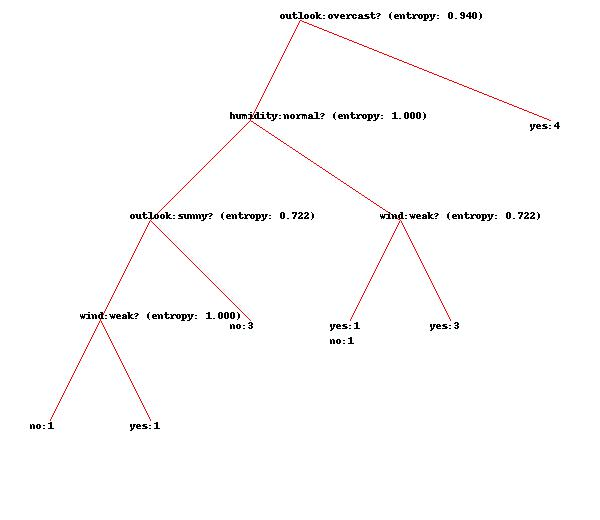

In [24]:
from IPython.display import Image

Image('tennis.jpg')

# Right path always taken when node `true`

    Right path is always taken when the node turns out to be `true`

# Running Code on the Assignment Data

## Classiyfing the Car Dataset by the ID3 Decision Tree

In [25]:
# Load data

path = '/Users/slackoverflow/Dropbox/DKE/Machine Learning/Decision Trees/ID3/data.csv'
data = pd.read_csv(path)

### Check dataset

In [26]:
# display first 5 rows
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7
0,0,0.0,vhigh,vhigh,2.0,2.0,small,low,unacc
1,1,1.0,vhigh,vhigh,2.0,2.0,small,med,unacc
2,2,2.0,vhigh,vhigh,2.0,2.0,small,high,unacc
3,3,3.0,vhigh,vhigh,2.0,2.0,med,low,unacc
4,4,4.0,vhigh,vhigh,2.0,2.0,med,med,unacc


### Check labels

In [27]:
set(data.values[:,-1])

{'acc', 'good', 'unacc', 'vgood'}

### We're dealing here with 4 classes, so we have to adjust the entropy accordingly to log base 4

In [28]:
def entropy(s):
    result = count_labels(s)
    from math import log2
    entropie = 0.0
    
    # for each label
    for label in result.keys():
        # calculate p first
        # => relative frequency
        p = float(result[label])/len(s)
        # if p not 0
        if(p):
            # calc entropy
            entropie -= p * log2(p)/log2(4) # <-------- log base 4 now
        
    return entropie

### Exclude first 2 columns -> ID vars and run ID3

In [29]:
# convert pandas DF to numpy array
data = data.values

# exclude first 2 cols
data = data[:,2:]

# erase labels from the previous tennis dataset
labels = None

## Run ID3 on Assignment Dataset

In [30]:
assignment = ID3(data)

### draw the tree and save as `jpg`

In [31]:
drawtree(assignment, 'ID3_CAR_FINAL_2016-11-15.jpg')

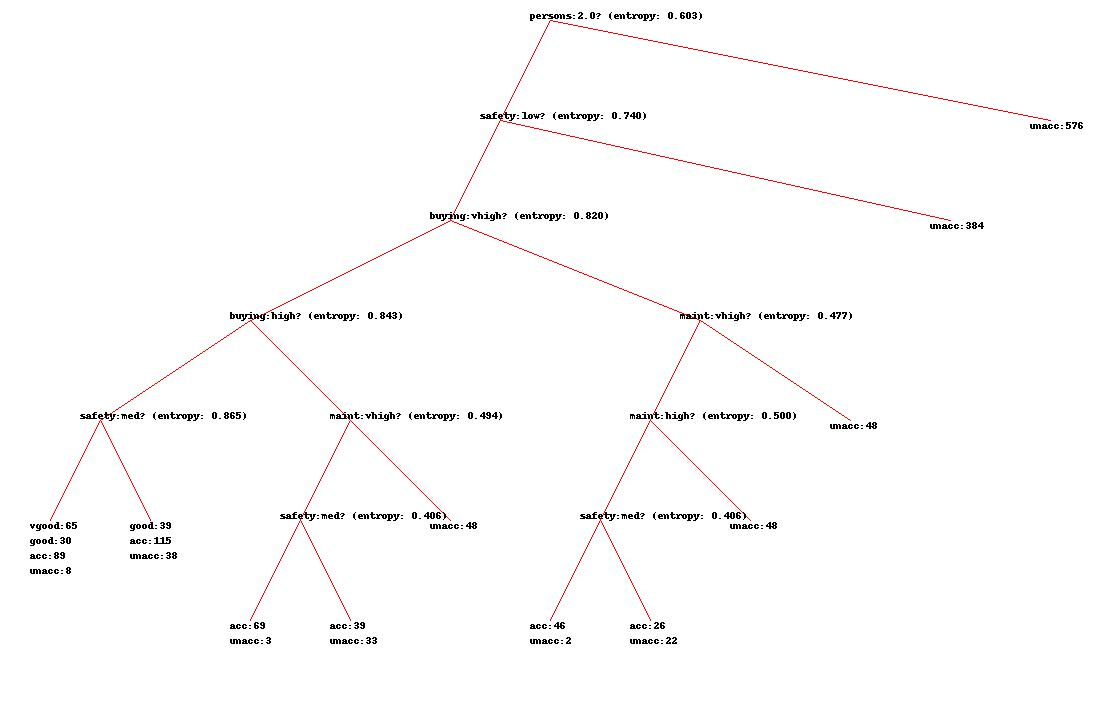

In [32]:
Image('ID3_CAR_FINAL_2016-11-15.jpg')

    Right path is always taken when the node turns out to be `true`

### Text Format

In [33]:
printtree(assignment)

persons:2.0? (entropy: 0.603)
True-> {'unacc': 576}
False-> safety:low? (entropy: 0.740)
  True-> {'unacc': 384}
  False-> buying:vhigh? (entropy: 0.820)
    True-> maint:vhigh? (entropy: 0.477)
      True-> {'unacc': 48}
      False-> maint:high? (entropy: 0.500)
        True-> {'unacc': 48}
        False-> safety:med? (entropy: 0.406)
          True-> {'acc': 26, 'unacc': 22}
          False-> {'acc': 46, 'unacc': 2}
    False-> buying:high? (entropy: 0.843)
      True-> maint:vhigh? (entropy: 0.494)
        True-> {'unacc': 48}
        False-> safety:med? (entropy: 0.406)
          True-> {'acc': 39, 'unacc': 33}
          False-> {'acc': 69, 'unacc': 3}
      False-> safety:med? (entropy: 0.865)
        True-> {'good': 39, 'acc': 115, 'unacc': 38}
        False-> {'vgood': 65, 'good': 30, 'acc': 89, 'unacc': 8}


#### Entropy of initial tree (debugging)

In [34]:
entropy(data)

0.6028704850060875